# Subject
The dataset for the project is distributed via private Kaggle InClass competition. You can access this via this link: https://www.kaggle.com/account/login?ReturnUrl=%2Ft%2F8e01943b0f17473098fe3b2409a02c65

The deadline is 15/11/2020 @ midnight CET. 

The outcome of your work should be a report (at least 3 pages long, not counting images and code). It should reflect your work on the dataset, motivation behind method choices, and analysis of model performance. It is encouraged to present not only successful, but also failed solutions, if they are supported by analysis and prove to be helpful in the search of the final solution. 

The report should be in PDF form (which can be generated from a Jupyter notebook)

# Objectivs

Kaggle says : "In this competition you are challenged with a digits classification task. The images are similar to MNIST, however they contain the background noise."

So the goal is to build a classification model to classify the provided dataset that is a noisy version of MNIST

# Getting the data

My idea is to use GoogleColab to be able to use its GPU if needed.
To be able to work with GoogleColab I have zipped that I get from Kaggle and I have put them in my personal GoogleDrive.
Since GoogleColab do not provide a permanent storage, this is a way to be able to get the dataset each time I run GoogleColab.

**Connect to my personal Google Drive**

In [116]:
import numpy as np
import seaborn as sns; sns.set()
import cv2
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,Activation
from keras.models import Sequential
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler,ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report,confusion_matrix

from time import time
from matplotlib import pyplot as plt
import pandas as pd

import tensorflow as tf
from keras.optimizers import RMSprop,Adam
import random as rand

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        


1 Physical GPUs, 1 Logical GPUs


In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
#device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [62]:
num_classes = 10
list_classes = [str(i) for i in range(num_classes)]
IMAGE_SIZE = 28

In [85]:
def show_classification_confusion_matrix(y_valid,y_fit,list_classes):
  print(classification_report(y_valid, y_fit,
                            target_names = list_classes))
  mat = confusion_matrix(y_valid, y_fit)
  plt.figure()
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list_classes,
            yticklabels=list_classes)
  plt.xlabel('true label')
  plt.ylabel('predicted label')

def show_loss_accuracy(result):
    plt.figure()
    fig, axes = plt.subplots(1, 2,figsize=(18, 4))
    # plot accuracy on training and validation data
    df_history = pd.DataFrame(result.history)
    sns.lineplot(ax=axes[0],data=df_history[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);
    # plot loss on training and validation data
    df_history = pd.DataFrame(result.history)
    sns.lineplot(ax=axes[1],data=df_history[['loss','val_loss']], palette="tab10", linewidth=2.5);

**Load datas into numpy table structure**
- images for the train data
- images_test for the test data

In [64]:
data_train = np.loadtxt(open("data/train_data.csv", "rb"), delimiter=",")



In [65]:
data_test = np.loadtxt(open("data/test_data.csv", "rb"), delimiter=",")

# Looking at the dataset

**Train dataset**



In [7]:
print(data_train.shape)
data_train[0:2]

(12000, 785)


array([[0.71393964, 0.95016594, 0.08249079, ..., 0.55627015, 0.69829481,
        5.        ],
       [0.20744189, 0.15994205, 0.05264073, ..., 0.20319134, 0.39100319,
        7.        ]])

- the train dataset has 12000 rows and 785 columns
- each row can be splitted into : the first 784 column which contain the picture information and the last row which contains the expected value of the number to be classified in the image
So I split the train dataset into two parts :
- label : with only the labels
- images : with only the images

In [67]:
label=data_train[:,-1]

images=data_train[:,0:-1]

**The dataset is well balanced**

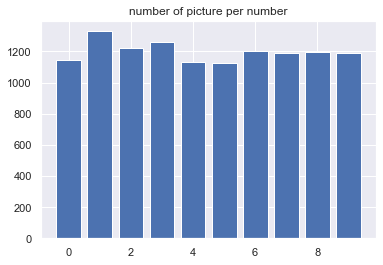

In [9]:
number, count = np.unique(label, return_counts=True)
plt.title('number of picture per number')
plt.bar(number, height=count)
plt.show()

**Test dataset**

In [156]:
print(data_test.shape)
data_test[0:2]

(50000, 784)


array([[0.923635  , 0.84568737, 0.39288922, ..., 0.91443564, 0.20895224,
        0.81808189],
       [0.00776682, 0.67074047, 0.95102143, ..., 0.68060272, 0.67633705,
        0.95092055]])

The test dataset has 50000 rows. Each rows has 784 column for the image data.

## Looking at the pictures
The 784 columns are in fact an array of 28x28 pixels. We only have one array so this means we have black and white pictures with different grey levels.  
I am printing 25 random pictures from the train dataset with their labels to have an idea about the pictures and the noise

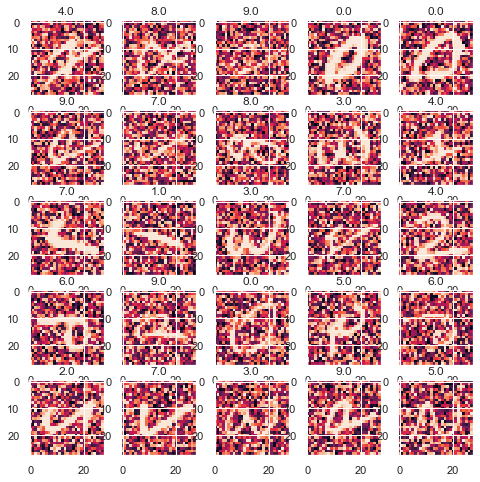

In [9]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(0, columns*rows ):
    r=rand.randint(0,11999)
    img = images[r,:].reshape(28,28)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, interpolation='nearest')
    plt.title(label[r])
plt.show()

We can see that :
- the level of noise is quit high and some figure are not easy to see
- the images are rotated and flipped.  
I use a transpose on the matrix to show the images on the usual way :

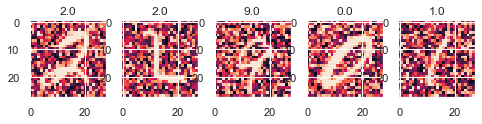

In [61]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 1
for i in range(0, columns*rows ):
    r=rand.randint(0,11999)
    img = images[r,:].reshape(28,28)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(np.transpose(img), interpolation='nearest')
    plt.title(label[r])
plt.show()

# Using SVM for classification

My first idea is to use SVM for the classification. Even if I think neural network should be able to do better it would be a good start to have a first quick reference.  
Since the number of features is quite high, I choose a mix between PCA (to reduce the number of features) and SVM for classification.

And I have defined a grid search strategy to try to find best parameters for both PCA and SVM.

I am using for this grid search the whole train dataset, since this gridsearch function is doing cross validation folder by itself with this dataset.

**Preparing the data for the PCA/SVM**
- x_grid used for the grid search
- x_train to train the model when the hyperparameters are choosen
- x_valid to predict and evaluate the accuracy of the model  
The splitting is done in order to keep the same balance as the initial balance

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(images, label,test_size=0.2,stratify=label,shuffle=True)

x_train = np.array(x_train).astype('float32')
x_valid = np.array(x_valid).astype('float32')

x_grid = np.array(images).astype('float32')

In [120]:
pca = RandomizedPCA(n_components=150, whiten=True, svd_solver='randomized')
svc = SVC( class_weight='balanced')
model = make_pipeline(pca, svc)

from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'svc__kernel': ['rbf'], 'svc__gamma': [0.01,1e-3, 1e-4],
                     'svc__C': [1, 10, 100]},
                    {'svc__kernel': ['linear'], 'svc__C': [1, 10, 100]}]

grid_SVM = GridSearchCV(model, tuned_parameters,verbose=0)



In [121]:
grid_SVM.fit(x_grid, label)
print(grid_SVM.best_params_)


{'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


**So the best found parameters are : {svc__C=100, svc__gamma=0.01, svc__kernel=rbf}**  
I re-run the grid search to be a bit more precise and I add also the number of component of the PCA as a parameter to see the impact.

In [122]:
pca = RandomizedPCA(n_components=150, whiten=True, svd_solver='randomized')
svc = SVC( kernel = 'rbf',class_weight='balanced')
model = make_pipeline(pca, svc)

tuned_parameters = [{'pca__n_components' : [50, 100, 150 ], 'svc__gamma': [0.1,0.05,0.01],
                     'svc__C': [100]}]

grid_SVM = GridSearchCV(model, tuned_parameters,verbose=0)

In [123]:
grid_SVM.fit(x_grid, label)
print(grid_SVM.best_params_)

{'pca__n_components': 50, 'svc__C': 100, 'svc__gamma': 0.05}


After this second steps the best parameters are : {'pca__n_components': 50, 'svc__C': 100, 'svc__gamma': 0.05}


In [124]:
pca = RandomizedPCA(n_components=50, whiten=True, svd_solver='randomized')
svc = SVC( kernel = 'rbf',class_weight='balanced',C = 100, gamma = 0.05)
model_SVM = make_pipeline(pca, svc)

In [125]:
model_SVM.fit(x_train, y_train)

Pipeline(steps=[('pca',
                 PCA(n_components=50, svd_solver='randomized', whiten=True)),
                ('svc', SVC(C=100, class_weight='balanced', gamma=0.05))])

I run the PCA/SVM on the training data and predict on the validation dataset in order to have an estimation of the classification accuracy.

In [126]:
y_fit = model_SVM.predict(x_valid)

**In conclusion, with PCA/SVM the accuracy on the validation dataset is : 90%**

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       344
           1       0.89      0.97      0.93       399
           2       0.92      0.90      0.91       366
           3       0.89      0.83      0.86       379
           4       0.88      0.90      0.89       339
           5       0.84      0.87      0.85       338
           6       0.94      0.94      0.94       361
           7       0.91      0.90      0.90       358
           8       0.86      0.86      0.86       358
           9       0.89      0.86      0.87       358

    accuracy                           0.90      3600
   macro avg       0.90      0.90      0.90      3600
weighted avg       0.90      0.90      0.90      3600



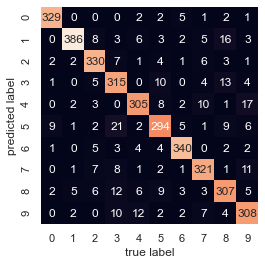

In [127]:
show_classification_confusion_matrix(y_valid,y_fit,list_classes)

# CNN Neural Network - simple structure

Now I will use a classical CNN neural network usually used on the MNIST dataset.  

## Preparing the data for the CNN

Here I reshape the datasets (x_train,x_valid,x_grid) so construct 28*28 matrix  
I also transpose this matrix to make the display of the pictures more visual and add a channel dimension to fit with the CNN network

In [68]:


x_train_resized = [np.transpose(img.reshape(IMAGE_SIZE,IMAGE_SIZE)) for img in (x_train )]
x_valid_resized = [np.transpose(img.reshape(IMAGE_SIZE,IMAGE_SIZE)) for img in (x_valid )]
x_grid_resized = [np.transpose(img.reshape(IMAGE_SIZE,IMAGE_SIZE)) for img in (x_grid )]

x_train_resized = np.array(x_train_resized).astype('float32')
x_valid_resized = np.array(x_valid_resized).astype('float32')
x_grid_resized = np.array(x_grid_resized).astype('float32')

x_train_resized = x_train_resized.reshape(x_train_resized.shape[0], x_train_resized.shape[1], x_train_resized.shape[2], 1)
x_valid_resized = x_valid_resized.reshape(x_valid_resized.shape[0], x_valid_resized.shape[1], x_valid_resized.shape[2], 1)
x_grid_resized = x_grid_resized.reshape(x_grid_resized.shape[0], x_grid_resized.shape[1], x_grid_resized.shape[2], 1)

**Transform numerical variables into categorical variable**

In [69]:

# convert the target variable 
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_valid_cat = keras.utils.to_categorical(y_valid, num_classes)
y_grid_cat = keras.utils.to_categorical(label, num_classes)

## Building the CNN

In [128]:
model_simple = Sequential()
# add first convolutional layer MODIF
model_simple.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
model_simple.add(MaxPooling2D(pool_size=(2, 2)))
# add second convolutional layer MODIF
model_simple.add(Conv2D(32, kernel_size=(5, 5),padding='same', activation='relu'))
# add one max pooling layer 
model_simple.add(MaxPooling2D(pool_size=(2, 2)))
# add flatten layer
model_simple.add(Flatten())
# add dense layer
model_simple.add(Dense(128,activation='relu'))
# add dense layer
model_simple.add(Dense(num_classes, activation='softmax'))
model_simple.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy']) 


In [129]:
res_simple = model_simple.fit(x_train_resized,y_train_cat,batch_size=64,
                              epochs=100,validation_data=(x_valid_resized, y_valid_cat),verbose=0)

<Figure size 432x288 with 0 Axes>

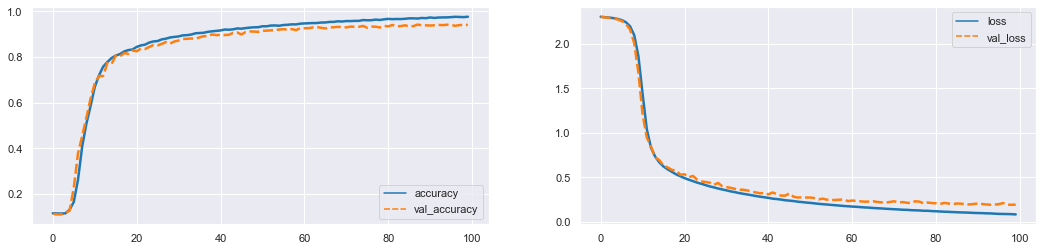

In [130]:
  show_loss_accuracy(res_simple)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       344
           1       0.95      0.97      0.96       399
           2       0.96      0.95      0.95       366
           3       0.92      0.95      0.94       379
           4       0.95      0.92      0.94       339
           5       0.95      0.93      0.94       338
           6       0.98      0.96      0.97       361
           7       0.94      0.94      0.94       358
           8       0.94      0.89      0.92       358
           9       0.88      0.91      0.89       358

    accuracy                           0.94      3600
   macro avg       0.94      0.94      0.94      3600
weighted avg       0.94      0.94      0.94      3600



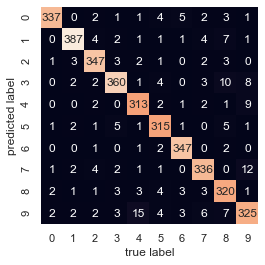

In [131]:
y_fit = [np.argmax(i) for i in model_simple.predict(x_valid_resized)]
show_classification_confusion_matrix(y_valid,y_fit,list_classes)

**With this "simple" CNN the result is improved to around 94% accuracy : better then the result found for SVM**

Looking at the loss and accuracy curves :
- after 30/40 epochs the validation loss start increasing wherease the training loss decreases 
- the final result in terme of accuracy is around 95% : far from what CNN can do with traditional MNIST dataset so I can hope to improve the model

So my ideas to improve this result is to tune the hyper parameters of my modele :
- initialisation of the weights
- optimizer
- number of batch
- number of epoch
- kind of activation used  

To do this I use the GridSearchCV function that realize both grid search on hyperparameters and cross validation with 5 folders to evaluate the best choice.

In [133]:
def create_model_simple(optimizer='rmsprop', init='uniform', activation = 'relu'):
    model_simple = Sequential()
    # add first convolutional layer MODIF
    model_simple.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation=activation, kernel_initializer=init,input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model_simple.add(MaxPooling2D(pool_size=(2, 2)))
    # add second convolutional layer MODIF
    model_simple.add(Conv2D(32, kernel_size=(5, 5),padding='same', kernel_initializer=init, activation=activation))
    # add one max pooling layer 
    model_simple.add(MaxPooling2D(pool_size=(2, 2)))
    # add flatten layer
    model_simple.add(Flatten())
    # add dense layer
    model_simple.add(Dense(128,activation=activation,kernel_initializer=init))
    # add dense layer
    model_simple.add(Dense(num_classes, activation='softmax'))
    model_simple.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
    return model_simple
    
model = KerasClassifier(build_fn=create_model_simple)

In [ ]:
param_grid = {
              'epochs':[10],
              'batch_size':[32,64,128],
              'optimizer' :           ['Adam', 'Nadam','rmsprop'],
              'activation' :          ['relu','sigmoid'],
              'init' :  ['normal','uniform']
             }

grid = GridSearchCV(estimator=model, param_grid=param_grid,verbose=0)
grid_result = grid.fit(x_grid_resized, y_grid_cat,verbose=0)

In [135]:
df_grid_results = pd.DataFrame(grid_result.cv_results_)
df_grid_results.loc[:,('rank_test_score','mean_test_score','std_test_score','param_activation','param_batch_size','param_optimizer','param_init','param_epochs')].sort_values('rank_test_score')

,rank_test_score,mean_test_score,std_test_score,param_activation,param_batch_size,param_optimizer,param_init,param_epochs
1,1,0.953000,0.008343,relu,32,Nadam,normal,10
7,2,0.952667,0.005692,relu,64,Nadam,normal,10
0,3,0.950833,0.006084,relu,32,Adam,normal,10
2,4,0.950500,0.008368,relu,32,rmsprop,normal,10
13,5,0.949333,0.004295,relu,128,Nadam,normal,10
11,6,0.949083,0.004605,relu,64,rmsprop,uniform,10
10,7,0.948333,0.005798,relu,64,Nadam,uniform,10
8,8,0.947667,0.005837,relu,64,rmsprop,normal,10
5,9,0.947417,0.003665,relu,32,rmsprop,uniform,10
4,10,0.946750,0.002065,relu,32,Nadam,uniform,10


The result of this grid search is that the best hyper parameters are :
* init : normal
* batch : 32 or 64 is close
* optimizer : 'nadam' and 'rmsprop' are close
* activation : 'relu'
So I decide to run a new gridsearchCV including this time bigger epoch and to keep open the choice for optimizer and batch size.

In [ ]:
param_grid = {
              'epochs':[20,50,100],
              'batch_size':[32,64],
              'optimizer' :           [ 'Nadam','rmsprop'],
              'activation' :          ['relu'],
              'init' :  ['normal']
             }

grid = GridSearchCV(estimator=model, param_grid=param_grid,verbose=0)
grid_result = grid.fit(x_grid_resized, y_grid_cat,verbose=0)

In [137]:
df_grid_results = pd.DataFrame(grid_result.cv_results_)
df_grid_results.loc[:,('rank_test_score','mean_test_score','std_test_score','param_activation','param_batch_size','param_optimizer','param_init','param_epochs')].sort_values('rank_test_score')

,rank_test_score,mean_test_score,std_test_score,param_activation,param_batch_size,param_optimizer,param_init,param_epochs
2,1,0.961417,0.002721,relu,32,Nadam,normal,50
4,2,0.959333,0.006042,relu,32,Nadam,normal,100
0,3,0.957167,0.006069,relu,32,Nadam,normal,20
8,4,0.955250,0.004704,relu,64,Nadam,normal,50
10,5,0.954167,0.003575,relu,64,Nadam,normal,100
6,6,0.953833,0.003627,relu,64,Nadam,normal,20
7,7,0.952750,0.003860,relu,64,rmsprop,normal,20
3,8,0.952750,0.006267,relu,32,rmsprop,normal,50
1,9,0.951250,0.003039,relu,32,rmsprop,normal,20
11,9,0.951250,0.004602,relu,64,rmsprop,normal,100


This grid search gives the better results for :
* optimizer : Nadam
* batch_size : 32
* epoch 100


# Adding new layers

In order to try to improve the model I add more layers :
* replace the convolution layer with kernel(5,5) by two layers with kernet (3,3)
* replace the max pooling layer by a CNN layer with kernel(5,5) and a strides of 2 : this has mostly the same effect with the ability to have parameters
* add dropout layers for a better learning
* add batch normalization to try to fix the vanishing gradient problem

I fix the activation to 'relu' and let the inititialization to default ('glorot_uniform')


In [81]:
def create_model_complexe(optimizer='rmsprop', dropout_rate = 0.5):
    model = Sequential()

    model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(dropout_rate))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) 

    return model



model_complexe_grid = KerasClassifier(build_fn=create_model_complexe)



I do a first try with the hyper parameters that I have selected above and a dropout ratio of 0.5

In [138]:
# optimize parameters of the fit method 
model_complexe = create_model_complexe(optimizer='nadam',
                          dropout_rate = 0.5)

res_complexe = model_complexe.fit(x_train_resized,y_train_cat,batch_size=32,
                              epochs=20,validation_data=(x_valid_resized, y_valid_cat),verbose=0)



              precision    recall  f1-score   support

           0       0.98      0.99      0.98       344
           1       0.95      0.99      0.97       399
           2       0.93      0.97      0.95       366
           3       0.93      0.98      0.96       379
           4       0.98      0.93      0.95       339
           5       0.91      0.98      0.94       338
           6       0.99      0.95      0.97       361
           7       0.97      0.96      0.96       358
           8       0.99      0.88      0.93       358
           9       0.97      0.94      0.95       358

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



<Figure size 432x288 with 0 Axes>

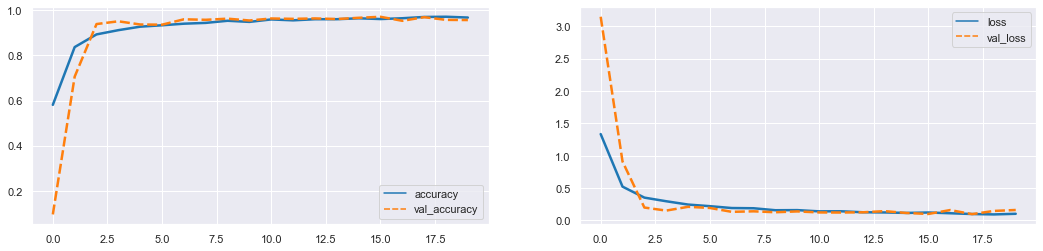

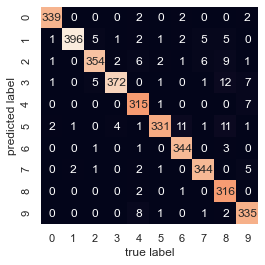

In [139]:
show_loss_accuracy(res_complexe)
y_fit = [np.argmax(i) for i in model_complexe.predict(x_valid_resized)]
show_classification_confusion_matrix(y_valid,y_fit,list_classes)

The best val_accuracy is close to 97%. A clear improvment.

I do again a grid search to see if previous best parameters are still ok and to try to find best parameter for dropout rate.

For this I add call_back function : early_stop to stop search when no more improvment in order to increase the speed of the grid search

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=0, mode='min')

param_grid = {
              'epochs':[100],
              'batch_size':[32],
              'optimizer' :           ['nadam','rmsprop'],
              'dropout_rate' :        [0.3,0.35,0.4,0.45, 0.5],
             }

grid = GridSearchCV(estimator=model_complexe_grid, param_grid=param_grid,verbose=0)
grid_result = grid.fit(x_grid_resized, y_grid_cat,callbacks = [
                                  early_stop
                                  ],verbose=0)

In [142]:
df_grid_results = pd.DataFrame(grid_result.cv_results_)
df_grid_results.loc[:,('rank_test_score','mean_test_score','std_test_score',
                       'param_batch_size','param_optimizer','param_epochs','param_dropout_rate')].sort_values('rank_test_score')

,rank_test_score,mean_test_score,std_test_score,param_batch_size,param_optimizer,param_epochs,param_dropout_rate
3,1,0.974167,0.002541,32,rmsprop,100,0.35
9,2,0.973667,0.004883,32,rmsprop,100,0.5
2,3,0.973500,0.001818,32,nadam,100,0.35
1,4,0.972917,0.001826,32,rmsprop,100,0.3
7,5,0.972583,0.005918,32,rmsprop,100,0.45
5,6,0.972417,0.002392,32,rmsprop,100,0.4
6,7,0.971750,0.003903,32,nadam,100,0.45
0,8,0.971000,0.004351,32,nadam,100,0.3
4,9,0.970833,0.003819,32,nadam,100,0.4
8,10,0.970000,0.004617,32,nadam,100,0.5


I keep the following parameters (rmsprop, drop-out=0.35) and I re-run the model. I add the callback "ModelCheckpoint" that stores the best weights in order to be able to run it again on the test dataset and submit it on Kaggle



In [143]:
mcp_save = ModelCheckpoint('/temp/save/{epoch}_mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', 
                           mode='max',verbose = 0)

# optimize parameters of the fit method 
model_complexe = create_model_complexe(optimizer='rmsprop',
                          dropout_rate = 0.35)


res_complexe = model_complexe.fit(x_train_resized,y_train_cat,batch_size=32,
                              epochs=100,validation_data=(x_valid_resized, y_valid_cat),callbacks=[mcp_save],verbose=0)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       344
           1       0.98      0.99      0.99       399
           2       0.98      0.97      0.98       366
           3       0.99      0.99      0.99       379
           4       0.97      0.98      0.98       339
           5       0.97      0.99      0.98       338
           6       0.99      0.98      0.99       361
           7       0.97      0.97      0.97       358
           8       0.97      0.96      0.97       358
           9       0.97      0.96      0.97       358

    accuracy                           0.98      3600
   macro avg       0.98      0.98      0.98      3600
weighted avg       0.98      0.98      0.98      3600



<Figure size 432x288 with 0 Axes>

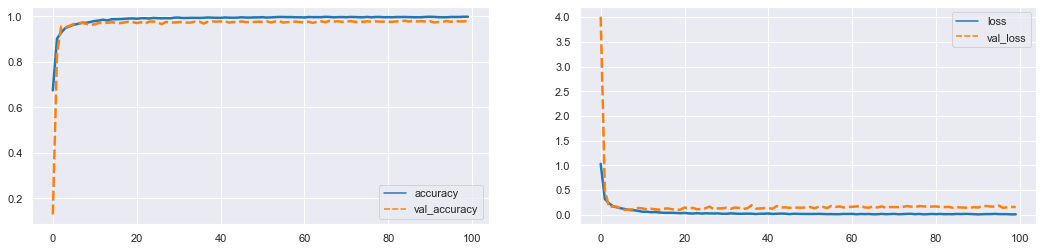

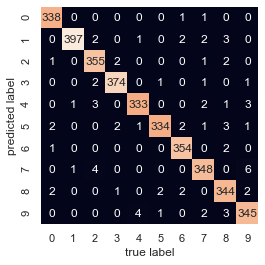

In [144]:
show_loss_accuracy(res_complexe)
y_fit = [np.argmax(i) for i in model_complexe.predict(x_valid_resized)]
show_classification_confusion_matrix(y_valid,y_fit,list_classes)

The best validation accuracy is 98,22%

**With this I obtain a score of  97.946 on Kaggle**

The result on Kaggle is under what I get on training and validation dataset. I will add data augmentation to try to reduce overfitting.

In [146]:
#define callbacks

mcp_save = ModelCheckpoint('/temp/save/{epoch}_mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max',verbose = 0)

# optimize parameters of the fit method 
grid_model = create_model_complexe(
                          optimizer='rmsprop',
                          dropout_rate = 0.35)
    
# With data augmentation 
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        fill_mode='constant', cval = 0.0)

datagen.fit(x_train_resized)

aug_history = grid_model.fit(datagen.flow(x_train_resized,y_train_cat, 32),
                                  epochs = 100, 
                                  validation_data = (x_valid_resized,y_valid_cat),
                                  verbose = 0, 
                                  steps_per_epoch = x_train_resized.shape[0] / 32
                                  ,callbacks = [
                                  mcp_save,
                                  ])

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       344
           1       0.98      0.99      0.99       399
           2       0.98      0.97      0.98       366
           3       0.99      0.99      0.99       379
           4       0.97      0.98      0.98       339
           5       0.97      0.99      0.98       338
           6       0.99      0.98      0.99       361
           7       0.97      0.97      0.97       358
           8       0.97      0.96      0.97       358
           9       0.97      0.96      0.97       358

    accuracy                           0.98      3600
   macro avg       0.98      0.98      0.98      3600
weighted avg       0.98      0.98      0.98      3600



<Figure size 432x288 with 0 Axes>

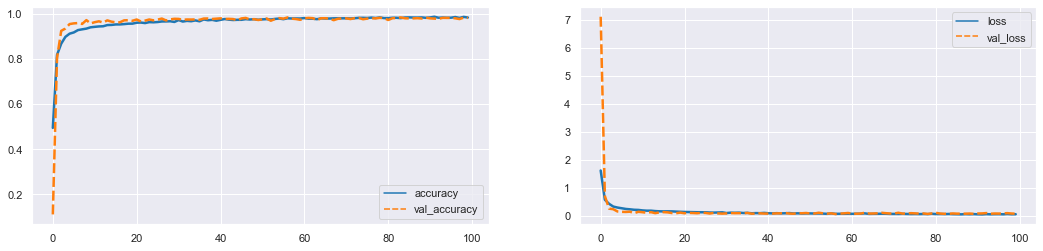

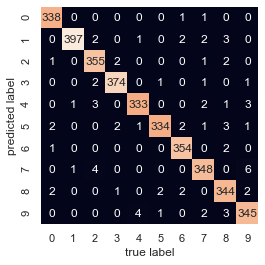

In [147]:
show_loss_accuracy(aug_history)
y_fit = [np.argmax(i) for i in model_complexe.predict(x_valid_resized)]
show_classification_confusion_matrix(y_valid,y_fit,list_classes)

In [ ]:
The best validation accuracy is 98,56

**With this setup I get my best result on Kaggle : 98.346**

## Train my best network on classical Mnist Network

Another idea is to try to do transfer learning from a pretrained model on "classical" Mnist dataset

In [30]:
img_rows = img_cols = 28
num_classes = 10

(X_train, Y_train),(X_valid, Y_valid) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
X_train, X_valid = X_train / 255.0, X_valid / 255.0

Y_train_cat = to_categorical(Y_train, num_classes)
Y_valid_cat = to_categorical(Y_valid, num_classes)

(60000, 28, 28, 1)
(60000,)


In [108]:
# optimize parameters of the fit method 
mnist_model = create_model_complexe(optimizer=RMSprop(),
                          dropout_rate = 0.35)
    
# With data augmentation 
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        fill_mode='constant', cval = 0.0)

datagen.fit(X_train)

history_mnist = mnist_model.fit_generator(datagen.flow(X_train,Y_train_cat, 64),
                                  epochs = 50, 
                                  validation_data = (X_valid,Y_valid_cat),
                                  verbose = 0, 
                                  steps_per_epoch = X_train.shape[0] / 64)

We achieve an accuracy of 99,63% and a validation accuracy of 99,63%

First test : we apply directly this model to our tain/validation data without any change.

C:\Users\erick\.conda\envs\digitreco\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.84      0.40      0.54       344
           1       0.67      0.01      0.01       399
           2       1.00      0.01      0.01       366
           3       0.45      0.73      0.56       379
           4       0.40      0.32      0.35       339
           5       0.94      0.04      0.08       338
           6       0.56      0.10      0.17       361
           7       0.00      0.00      0.00       358
           8       0.14      0.98      0.25       358
           9       0.00      0.00      0.00       358

    accuracy                           0.26      3600
   macro avg       0.50      0.26      0.20      3600
weighted avg       0.50      0.26      0.20      3600



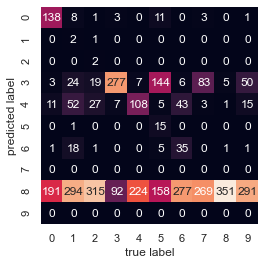

In [109]:
y_fit = [np.argmax(i) for i in mnist_model.predict(x_valid_resized)]
show_classification_confusion_matrix(y_valid,y_fit,list_classes)

The result is very bad, so I am trying to do transfer learning from the whole model.

So I train the same model using the already define weights but applying my dataset pictures.

In [110]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        fill_mode='constant', cval = 0.0)

datagen.fit(x_train_resized)


history_mnist = mnist_model.fit_generator(datagen.flow(x_train_resized,y_train_cat, 64),
                                  epochs = 100, 
                                  validation_data = (x_valid_resized,y_valid_cat),
                                  verbose = 0, 
                                  steps_per_epoch = x_train_resized.shape[0] / 64)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       344
           1       0.97      0.99      0.98       399
           2       0.99      0.98      0.99       366
           3       0.99      0.99      0.99       379
           4       0.99      0.98      0.98       339
           5       0.98      0.97      0.97       338
           6       0.99      0.99      0.99       361
           7       0.97      0.97      0.97       358
           8       0.98      0.98      0.98       358
           9       0.97      0.97      0.97       358

    accuracy                           0.98      3600
   macro avg       0.98      0.98      0.98      3600
weighted avg       0.98      0.98      0.98      3600



<Figure size 432x288 with 0 Axes>

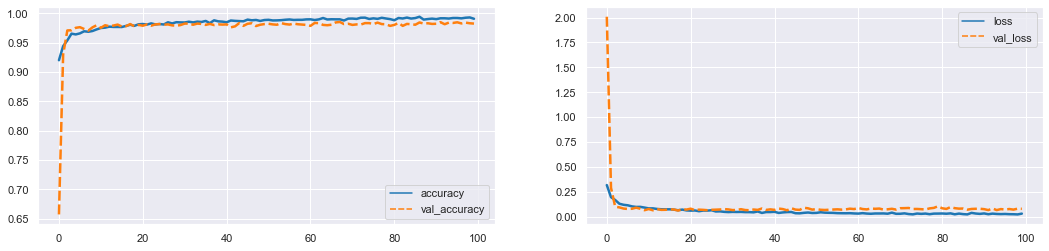

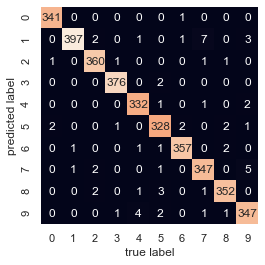

In [112]:
show_loss_accuracy(history_mnist)
y_fit = [np.argmax(i) for i in mnist_model.predict(x_valid_resized)]
show_classification_confusion_matrix(y_valid,y_fit,list_classes)

The result is good.

**The best saved val_accuracy gives a result of 98.153 on Kaggle with the test dataset**

Then I try to train only the last layers and to keep the CNN (feature detection part with no change from the MNist model)

In [114]:
for layer in grid_model.layers[0:-4]:
    layer.trainable = False  

In [115]:
grid_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [76]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        fill_mode='constant', cval = 0.0)

datagen.fit(x_train_resized)

history_mnist = mnist_model.fit_generator(datagen.flow(x_train_resized,y_train_cat, 64),
                                  epochs = 10, 
                                  validation_data = (x_valid_resized,y_valid_cat),
                                  verbose = 0, 
                                  steps_per_epoch = x_train_resized.shape[0] / 64)

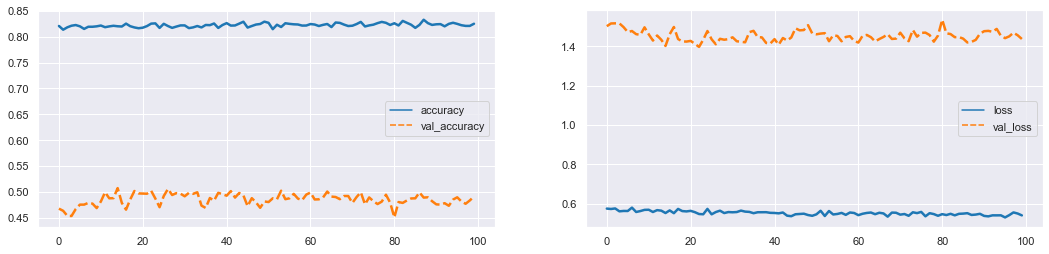

In [74]:
  show_loss_accuracy(history_mnist)

The result is not good the validation accuracy do not get above 0.5. So I stop here my tests

In [20]:
x_test = np.array(data_test).astype('float32')

In [21]:
x_test_resized = [np.transpose(img.reshape(28,28)) for img in (x_test )]
x_test_resized = np.array(x_test_resized).astype('float32')

In [22]:
x_test_resized = x_test_resized.reshape(x_test_resized.shape[0], x_test_resized.shape[1], x_test_resized.shape[2], 1)

In [156]:
predict_final = grid_model.predict(x_test_resized)

In [157]:
a_file = open("images_text_14112020v2.txt", "w")
a_file.write("Id,Category\n")
for i in range(predict_final.shape[0]):
    a_file.write(str(i) + ',' + str(np.argmax(predict_final[i])) + "\n")
a_file.close()

# Other tests

I also try other things but with no improvment of the scores.

My idea was for instance to remove the noise by another technic.

The simplest way to do it is to apply a threshold (for instance 0.95) at the picture in order to get a "Black and White" image with (0 and 1). The visual effect is qui good but the result in term of recognition is not good. I think it is because too much information is lost by this filtering.

I also try other "Callback" option available in Keras :
* LearningRateScheduler and ReduceLROnPlateau to decrease learning rate dynamically
* EarlyStopping : to stop searching and consequently try to avoid overfitting

I do not find better solution when using these "Callback"




# Conclusion

My best kaggle score : 98.346 has been reach with the following model :

    model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, kernel_size = 4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(dropout_rate))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

and the following hyperparameters
* batch size 64
* optimiser : rmsprop
* droput rate 0.35  

and the following data-augmentation
* rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
* width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
* height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)